In [59]:
import xarray as xr
import pandas as pd
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as pl
import cartopy.crs as ccrs
from cartopy import feature as cfeature

import matplotlib.ticker as mticker
import matplotlib.dates as mdates

In [60]:
def plot_on_map(lon, lat, arr, cmap, LON0, vmin=None, vmax=None, label="SST"):
    """
    Plots given array using pcolormesh on a map using Plate Carree projection.
    """
    lats, lons = np.meshgrid(lat, lon)

    # set up figure
    LON0 = 180.
    TIKLABFS = 10
    AXLABFS = 12
    map_proj = ccrs.PlateCarree(central_longitude=LON0)
    fig = pl.figure(figsize=[8, 6])
    ax = fig.add_axes([0.10, 0.10, 0.90, 0.80], projection=map_proj)

    # plot array using pcolormesh
    im = ax.pcolormesh(lons, lats, arr, cmap=cmap,
                       vmin=vmin, vmax=vmax,
                       rasterized=True, alpha=0.95,
                       transform=ccrs.PlateCarree()
                       )
    cb = pl.colorbar(im, shrink=0.90)
    cb.set_label("%s (deg C)" % label, fontsize=AXLABFS)

    # add land colors and coastlines
    land_50m = cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor="lightgray",
                                        alpha=0.65, zorder=-1)
    ax.add_feature(land_50m)
    ax.coastlines(linewidth=0.50, color="k", alpha=0.50)

    # set limits of the plot and grid lines
    ax.set_ylim(-66, 66)
    ax.set_xlim(-60., 120)
    gl = ax.gridlines(draw_labels=True, dms=True,
                      x_inline=False, y_inline=False,
                      linestyle="-", linewidth=0.50,
                      color="0.5",alpha=0.15)

    # add axis ticks and set tick label sizes
    gl.xlocator = mticker.FixedLocator(np.arange(-180, 181, 20))
    gl.ylocator = mticker.FixedLocator(np.arange(-65, 66, 15))
    gl.xlabel_style = {"fontsize": TIKLABFS}
    gl.ylabel_style = {"fontsize": TIKLABFS}

    return fig

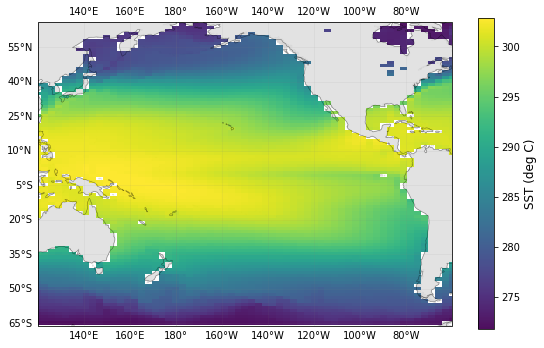

In [61]:
# load data
ds = xr.open_dataset("sst_1979_2020_pacific_coarse.nc")

# extract sst data and convert from Kelvin to degree Celsius
sst = ds.sst.to_masked_array()
sst = sst - 273.15

# sanity check: plot the mean on a map
fig = plot_on_map(ds.lon, ds.lat, ds.sst.mean(axis=0, skipna=True).T,
                  cmap="viridis", LON0=180)

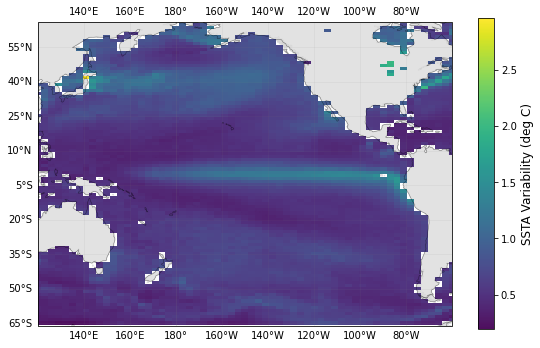

In [57]:
# calculate anomalies
ssta = np.zeros(sst.shape)
for i in range(12):
    ssta[i::12, :, :] = sst[i::12, :, :] - sst[i::12, :, :].mean(axis=0)
ssta = ma.masked_array(ssta, mask=sst.mask)

# sanity check: plot the SSTA standard deviation on a map
fig = plot_on_map(ds.lon, ds.lat, ssta.std(axis=0).T,
                  cmap="viridis", LON0=180,
                  label="SSTA Variability")

In [29]:
# covariance matrix of the anomaly time series
ssta_1d =ssta.reshape(ssta.shape[0], ssta.shape[1] * ssta.shape[2])
ssta_1d_data = ma.compress_cols(ssta_1d)
cov_ssta = np.cov(ssta_1d_data.T)


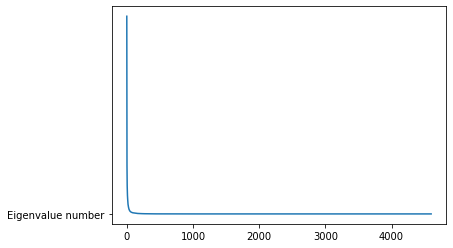

In [58]:
# compute the eigenvalues and eigenvectors of the covariance matrix
l, ev = np.linalg.eigh(cov_ssta)
l, ev = l[::-1], ev[:, ::-1]
pl.plot(l)
pl.plot("Eigenvalue number")

(0.0, 100.0)

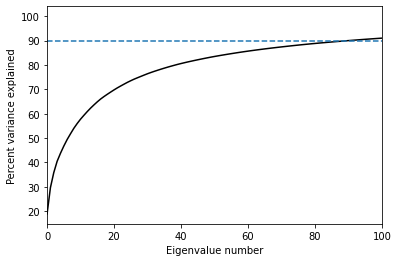

In [35]:
# compute the variance explained
var_exp = np.cumsum((l / l.sum()) * 100)
pl.plot(var_exp, "k")
pl.axhline(90., ls="--")
pl.xlabel("Eigenvalue number")
pl.ylabel("Percent variance explained")
pl.xlim(0, 100)

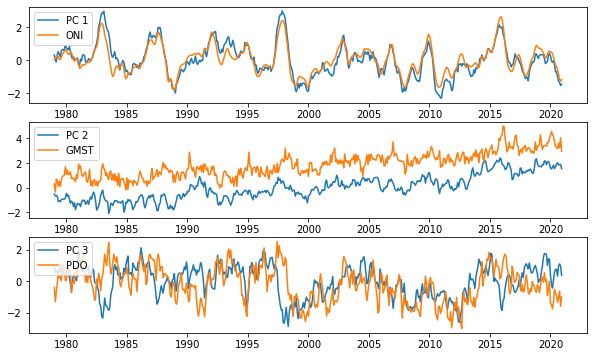

In [43]:
# visualise the top three principal components
# proj_X_ev1 = X * ev1
fig, axes = pl.subplots(3, 1, figsize=[10, 6])
pc = np.zeros((3, ssta_1d_data.shape[0]))
for i in range(pc.shape[0]):
    pc[i] = np.matmul(ssta_1d_data, ev[:, i])
    pc[i] /= pc[i].std()
    axes[i].plot(ds.time, pc[i], label="PC %d" % (i + 1))
    if i == 0:
        df = pd.read_csv("oni.csv", index_col=0).squeeze()
        axes[i].plot(ds.time, df, label="ONI")
    elif i == 1:
        df = pd.read_csv("gmst.csv", index_col=0).squeeze()
        df /= df.std()
        axes[i].plot(ds.time, df, label="GMST")
    elif i == 2:
        df = pd.read_csv("pdo.csv", index_col=0).squeeze()
        axes[i].plot(ds.time, df, label="PDO")        
    axes[i].legend(loc="upper left")


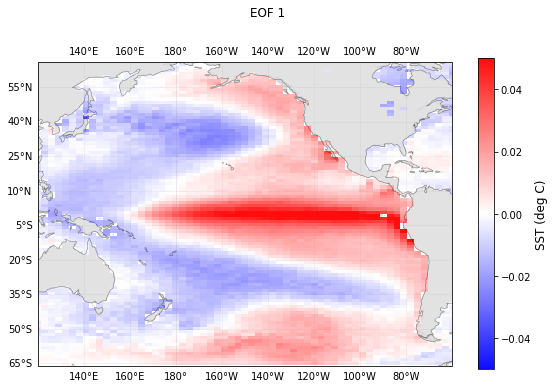

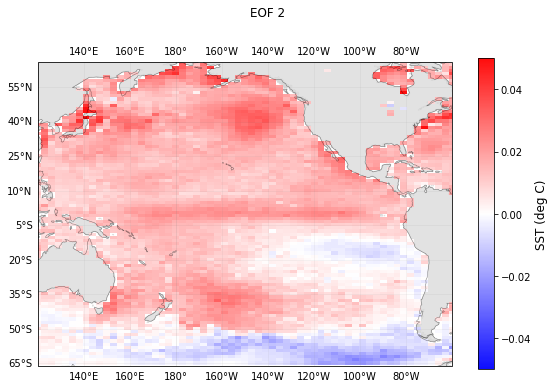

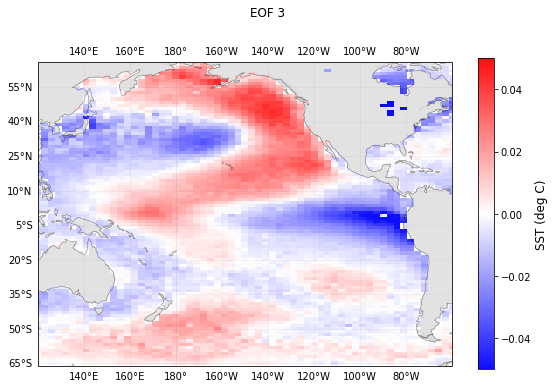

In [53]:
# visualise the top three EOFs
eofs_2d = ma.masked_array(np.zeros((3, ssta.shape[1], ssta.shape[2])))
for i in range(eofs_2d.shape[0]):
    eof_1d_mask = ssta_1d.mean(axis=0).mask
    eof_1d = ma.masked_array(np.zeros((ssta_1d.shape[1])),
                              mask=eof_1d_mask)
    eof_1d[~eof_1d_mask] = ev[:, i]
    eofs_2d[i] = eof_1d.reshape(ssta.shape[1], ssta.shape[2])
    fig = plot_on_map(ds.lon, ds.lat, eofs_2d[i].T,
                      cmap="bwr", LON0=180,
                      vmin=-0.05, vmax = 0.05
                      )
    fig.suptitle("EOF %d" % (i + 1))